# Circulating strain NY-2011-1202O neutralization with pseudovirus

This notebook produces the neutralization plot in Figure 6D for the strain NY-2011-1202O. Note below that this is referred to as 'QEJ' out of notation convenience. This has neutralization data for the antibodies 17C7 and CR4098.

Note that this depends on a raw data file in the 'RawData' directory:
- 241003_QEJ-PV_neut_data.xlsx: raw luciferase read data
- 241003_AntibodyNeut_Map.xlsx: notes antibody layout and the max concentration of each antibody



In [1]:
import pandas as pd
from matplotlib import pyplot as pl
#import seaborn as sb
import numpy as np
import matplotlib.cm as cm
import scipy.stats
from matplotlib.colors import ListedColormap

In [2]:
#read in excel documents with data


Plate1_data = pd.read_excel('RawData/241003_QEJ-PV_neut_data.xlsx','QEJ');
Plate1_data['virus']='QEJ';



Plate2_data = pd.read_excel('RawData/241003_QEJ-PV_neut_data.xlsx','PV');
Plate2_data['virus']='PV';




#antibody map

antibody_map = pd.read_excel('RawData/241003_AntibodyNeut_Map.xlsx');
antibody_map=antibody_map.rename(columns={"column": "Column"})



In [3]:
antibody_map

,Column,Antibody,Antibody_High_Conc
0,1,NaN,0
1,2,NaN,0
2,4,17C7,500
3,5,17C7,500
4,7,CR4098,2000
5,8,CR4098,2000
6,10,NaN,0
7,12,NaN,0


In [4]:
#process plate reader data from raw format

def format_plate_data(plate_df,antibodymap_df):
    #take plate_df and convert well into Row and Column
    plate_copy = plate_df.copy();

    plate_copy['Row']=plate_copy['Well'].apply(lambda x: x[0]);
    plate_copy['Column']=plate_copy['Well'].apply(lambda x: int(x[1:]));

    #something happened in rows A and H of the plates, so I will try fitting without those
    bad_rows = ['H'];
    plate_copy=plate_copy[plate_copy['Row'].isin(bad_rows)==False];
    #okay let's get the background values of the plate. Here, I'll take column 12 which only has media
    media_only = plate_copy[plate_copy['Column']==12]
    bg = media_only['RLU'].tolist();
    bg_median = np.median(bg);

    #okay let's now noise correct all RLU values
    plate_copy['RLU_bgsub'] = plate_copy['RLU'].apply(lambda x: x-bg_median);

    #now we need to merge in the antibody map and get concentrations.
    plate_copy = pd.merge(plate_copy,antibody_map,how='left',on=['Column'])

    #okay let's convert the Row values to an ordinal value for dilution factor.
    plate_copy['Dilution_factor']=plate_copy['Row'].apply(lambda x: ord(x)-65);
    plate_copy['antibody_conc']=plate_copy['Antibody_High_Conc']/5**plate_copy['Dilution_factor']

    #okay now we need to calculate the RLU fraction.
    columns = [2,10];
    
    no_antibody = plate_copy[plate_copy['Column'].isin(columns)];
    No_antibody_RLU_list = list(no_antibody['RLU_bgsub']);
    No_antibody_RLU = np.median(No_antibody_RLU_list);

    plate_copy['no_antibody_RLU'] = No_antibody_RLU;
    plate_copy['frac_infectivity']= plate_copy['RLU_bgsub'].apply(lambda x: x/No_antibody_RLU);

    
    return plate_copy;



In [5]:
Plate1_data_processed = format_plate_data(Plate1_data,antibody_map);
Plate2_data_processed = format_plate_data(Plate2_data,antibody_map);




In [6]:
Plate1_data_processed

,Well,Group,Type,Sample,RLU,Time [s],virus,Row,Column,RLU_bgsub,Antibody,Antibody_High_Conc,Dilution_factor,antibody_conc,no_antibody_RLU,frac_infectivity
0,A01,Group 1,Unknown,Un0001,1113.0,0.00,QEJ,A,1,914.1,NaN,0.0,0,0.000,770001.1,0.001187
1,A02,Group 1,Unknown,Un0002,727800.0,1.25,QEJ,A,2,727601.1,NaN,0.0,0,0.000,770001.1,0.944935
2,A03,Group 1,Unknown,Un0003,1883.0,2.50,QEJ,A,3,1684.1,NaN,NaN,0,NaN,770001.1,0.002187
3,A04,Group 1,Unknown,Un0004,502300.0,3.75,QEJ,A,4,502101.1,17C7,500.0,0,500.000,770001.1,0.652078
4,A05,Group 1,Unknown,Un0005,364200.0,5.00,QEJ,A,5,364001.1,17C7,500.0,0,500.000,770001.1,0.472728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,G08,Group 1,Unknown,Un0080,692100.0,98.85,QEJ,G,8,691901.1,CR4098,2000.0,6,0.128,770001.1,0.898572
80,G09,Group 1,Unknown,Un0081,2112.0,100.10,QEJ,G,9,1913.1,NaN,NaN,6,NaN,770001.1,0.002485
81,G10,Group 1,Unknown,Un0082,824900.0,101.35,QEJ,G,10,824701.1,NaN,0.0,6,0.000,770001.1,1.071039
82,G11,Group 1,Unknown,Un0083,1347.0,102.60,QEJ,G,11,1148.1,NaN,NaN,6,NaN,770001.1,0.001491


In [7]:
#okay maybe we should format some things to make neut-curve compatible.

neutCurve_subset_1=Plate1_data_processed[['virus','Antibody','frac_infectivity','antibody_conc','Column']];
neutCurve_subset_1 = neutCurve_subset_1.rename(columns={'Antibody':'serum','frac_infectivity':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})
                                                        

neutCurve_subset_2=Plate2_data_processed[['virus','Antibody','frac_infectivity','antibody_conc','Column']];
neutCurve_subset_2 = neutCurve_subset_2.rename(columns={'Antibody':'serum','frac_infectivity':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})


neutCurve_subset_1 = neutCurve_subset_1.dropna();
neutCurve_subset_2 = neutCurve_subset_2.dropna();

dfs = [neutCurve_subset_1,neutCurve_subset_2];

final = pd.concat(dfs);


In [8]:
neutCurve_subset_1

,virus,serum,fraction infectivity,concentration,replicate
3,QEJ,17C7,0.652078,500.000,4
4,QEJ,17C7,0.472728,500.000,5
6,QEJ,CR4098,0.014833,2000.000,7
7,QEJ,CR4098,0.007116,2000.000,8
16,QEJ,CR4098,0.016105,400.000,8
17,QEJ,CR4098,0.081884,400.000,7
19,QEJ,17C7,1.220779,100.000,5
20,QEJ,17C7,0.886753,100.000,4
27,QEJ,17C7,0.946623,20.000,4
28,QEJ,17C7,0.994805,20.000,5


In [9]:
import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

pd.set_option('display.float_format', '{:.3g}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

import os
import yaml

import neutcurve.parse_excel

In [10]:
fits = neutcurve.CurveFits(neutCurve_subset_1,fixtop=True)

In [11]:
fits.fitParams(ics=(50,90,99))

/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,QEJ,average,2,500,lower,>500,500,lower,>500,...,lower,>500,511,500,lower,11.4,1,0,0.539,0.15
1,CR4098,QEJ,average,2,0.531,interpolated,0.531,5.72,interpolated,5.72,...,interpolated,76.6,0.531,0.531,interpolated,0.924,1,0,0.966,0.0499


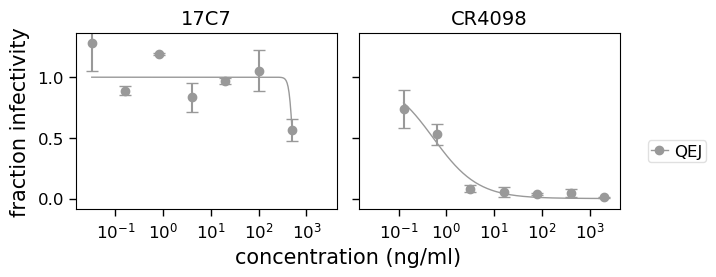

In [12]:
fig, axes = fits.plotSera(xlabel='concentration (ng/ml)',draw_in_bounds=True)

In [13]:
fits_2 = neutcurve.CurveFits(neutCurve_subset_2,fixtop=True)
fits_2.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,PV,average,2,0.163,interpolated,0.163,0.198,interpolated,0.198,...,interpolated,0.245,0.163,0.163,interpolated,11.3,1,0,0.958,0.0867
1,CR4098,PV,average,2,0.665,interpolated,0.665,7.3,interpolated,7.3,...,interpolated,99.8,0.665,0.665,interpolated,0.917,1,0,0.994,0.0227


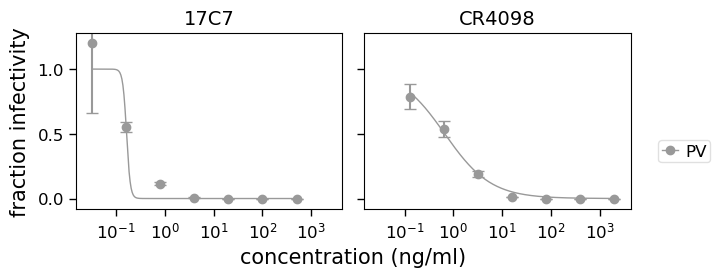

In [14]:
fig, axes = fits_2.plotSera(xlabel='concentration (ng/ml)',draw_in_bounds=True)

In [15]:
fits = neutcurve.CurveFits(final,fixtop=True)
fits.fitParams(ics=(50,90,99))

/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,QEJ,average,2,500,lower,>500,500,lower,>500,...,lower,>500,511,500,lower,11.4,1,0,0.539,0.15
1,17C7,PV,average,2,0.163,interpolated,0.163,0.198,interpolated,0.198,...,interpolated,0.245,0.163,0.163,interpolated,11.3,1,0,0.958,0.0867
2,CR4098,QEJ,average,2,0.531,interpolated,0.531,5.72,interpolated,5.72,...,interpolated,76.6,0.531,0.531,interpolated,0.924,1,0,0.966,0.0499
3,CR4098,PV,average,2,0.665,interpolated,0.665,7.3,interpolated,7.3,...,interpolated,99.8,0.665,0.665,interpolated,0.917,1,0,0.994,0.0227


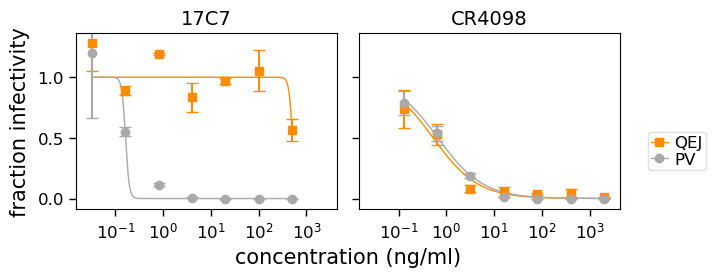

In [16]:
fig, axes = fits.plotSera(xlabel='concentration (ng/ml)',
                          virus_to_color_marker={'QEJ':('darkorange','s'),
                                                'PV':('darkgrey','o')},
                          draw_in_bounds=True,)
#fig.savefig('241202_QEJ_NeutCurves.svg');